In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Load the Dataset
df = pd.read_csv('TrafficTwoMonth.csv')

# Display column names and first few rows
print("Columns in the dataset:")
print(df.columns.tolist())

print("\nFirst 5 rows of the dataset:")
print(df.head())

# 2. Feature Engineering
# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Extract hour of the day from the 'Time' column
df['Hour'] = df['Time'].dt.hour

# Encode the 'Day of the week' column using Label Encoding
label_encoder = LabelEncoder()

df['Day of the week'] = label_encoder.fit_transform(df['Day of the week'])

# Create a binary feature for weekends (1 if weekend, 0 if weekday)
df['Weekend'] = df['Day of the week'].apply(lambda x: 1 if x >= 5 else 0)

# Create a feature for the total vehicle count
df['Total Vehicle Count'] = df['CarCount'] + df['BikeCount'] + df['BusCount'] + df['TruckCount']

# Create interaction terms for vehicle counts
df['Car_Bus_Count'] = df['CarCount'] * df['BusCount']
df['Car_Truck_Count'] = df['CarCount'] * df['TruckCount']
df['Bus_Truck_Count'] = df['BusCount'] * df['TruckCount']

# Display the updated dataset
print("\nUpdated dataset with new features:")
print(df.head())

# 3. Creating a Proxy for Speed
# Define base speeds for different traffic situations
base_speeds = {
    'low': 80,
    'normal': 60,
    'high': 40,
    'heavy': 30
}

# Create a proxy for truck speed based on traffic situation
df['Speed Proxy'] = df['Traffic Situation'].map(base_speeds)

# Display the dataset with the speed proxy
print("\nDataset with speed proxy:")
print(df.head())

# 4. Modeling Truck Speed
# Define features and target variable
X = df[['Hour', 'Day of the week', 'Weekend', 'Total Vehicle Count', 'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']]
y = df['Speed Proxy']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("\nMean Absolute Error (MAE) of the Random Forest model:", mae)

# the accuracy of the model
accuracy = r2_score(y_test, y_pred)
print("\nAccuracy of the Random Forest model:", accuracy)


# predict the speed for a new sample data  at 9:17 am on a Monday with 50 total vehicles, 10 cars, 15 trucks, and 20 buses.
sample_data = {
    'Hour': [9],
    'Day of the week': [0],
    'Weekend': [0],
    'Total Vehicle Count': [50],
    'Car_Bus_Count': [10 * 20],
    'Car_Truck_Count': [10 * 15],
    'Bus_Truck_Count': [20 * 15]
}

# Convert sample data to DataFrame
sample_df = pd.DataFrame(sample_data)

# Make speed predictions for the sample data
speed_prediction = rf.predict(sample_df)
print("\nPredicted speed for the sample data:", speed_prediction)

Columns in the dataset:
['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Traffic Situation']

First 5 rows of the dataset:
          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        13          2         2   
1  12:15:00 AM    10         Tuesday        14          1         1   
2  12:30:00 AM    10         Tuesday        10          2         2   
3  12:45:00 AM    10         Tuesday        10          2         2   
4   1:00:00 AM    10         Tuesday        11          2         1   

   TruckCount  Total Traffic Situation  
0          24     41            normal  
1          36     52            normal  
2          32     46            normal  
3          36     50            normal  
4          34     48            normal  

Updated dataset with new features:
                 Time  Date  Day of the week  CarCount  BikeCount  BusCount  \
0 2025-08-07 00:00:00    10              


Model Evaluation Results:
                    Model            Task  R² Score       MAE  Accuracy
0   RandomForestRegressor      Regression  0.950590  1.346644       NaN
1   DecisionTreeRegressor      Regression  0.932539  0.805369       NaN
2     KNeighborsRegressor      Regression  0.810576  3.392617       NaN
3        LinearRegression      Regression  0.678041  7.119439       NaN
4            XGBRegressor      Regression  0.956588  1.560277       NaN
5  RandomForestClassifier  Classification       NaN       NaN  0.953020
6  DecisionTreeClassifier  Classification       NaN       NaN  0.941275
7    KNeighborsClassifier  Classification       NaN       NaN  0.864094
8      LogisticRegression      Regression  0.593128  4.379195       NaN
9           XGBClassifier  Classification       NaN       NaN  0.974832

Models ordered by R² score for Regression task:
                   Model        Task  R² Score       MAE  Accuracy
4           XGBRegressor  Regression  0.956588  1.560277       Na

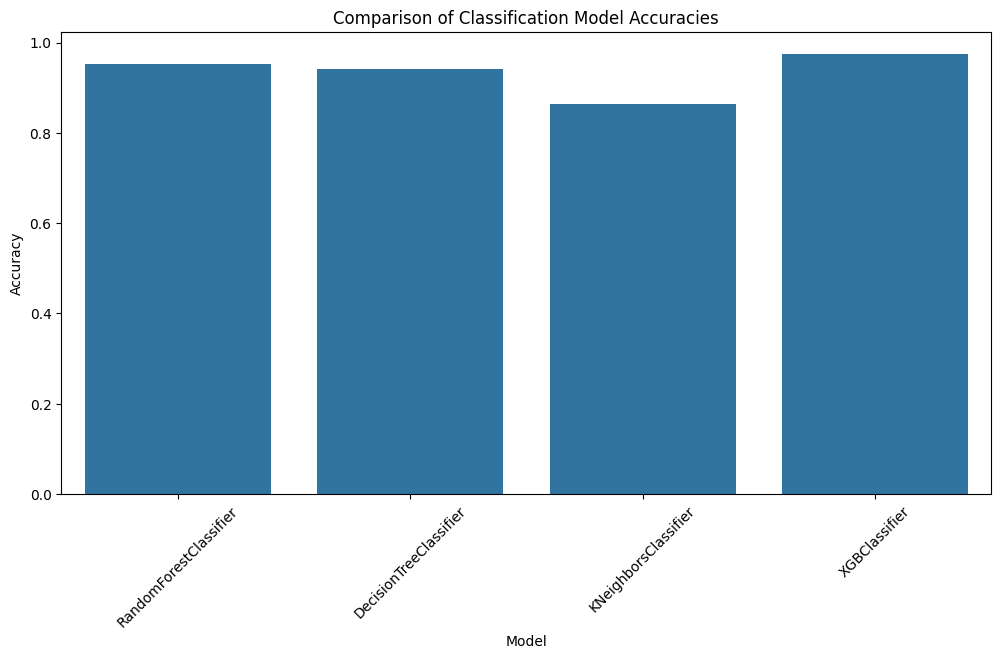

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Traffic.csv')

# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Feature Engineering: Extract hour and minute and convert to Time of Day in decimal format
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Time of Day'] = df['Hour'] + df['Minute'] / 60.0

# Encode 'Day of the week' and 'Traffic Situation'
label_encoder = LabelEncoder()
df['Day of the week'] = label_encoder.fit_transform(df['Day of the week'])

# Create other features
df['Weekend'] = df['Day of the week'].apply(lambda x: 1 if x >= 5 else 0)
df['Total Vehicle Count'] = df['CarCount'] + df['BikeCount'] + df['BusCount'] + df['TruckCount']
df['Car_Bus_Count'] = df['CarCount'] * df['BusCount']
df['Car_Truck_Count'] = df['CarCount'] * df['TruckCount']
df['Bus_Truck_Count'] = df['BusCount'] * df['TruckCount']

# Define base speeds for different traffic situations (for regression task)
base_speeds = {
    'low': 80,
    'normal': 60,
    'high': 40,
    'heavy': 30
}
df['Speed Proxy'] = df['Traffic Situation'].map(base_speeds)

# Feature selection
X = df[['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']]

# Models for Regression (Speed Prediction)
y_regression = df['Speed Proxy']

# Models for Classification (Traffic Situation Prediction)
df['Traffic Situation Encoded'] = label_encoder.fit_transform(df['Traffic Situation'])
y_classification = df['Traffic Situation Encoded']

# Split data into training and test sets for regression and classification tasks
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Define models for regression and classification
models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "LinearRegression": LinearRegression(),
    "XGBRegressor": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "XGBClassifier": xgb.XGBClassifier(random_state=42)
}

# Evaluate models and compare accuracy for classification and R² for regression
results = []

for name, model in models.items():
    if 'Classifier' in name:
        model.fit(X_train_cls, y_train_cls)
        y_pred_cls = model.predict(X_test_cls)
        accuracy = accuracy_score(y_test_cls, y_pred_cls)
        results.append({
            'Model': name,
            'Task': 'Classification',
            'Accuracy': accuracy
        })
    else:
        model.fit(X_train_reg, y_train_reg)
        y_pred_reg = model.predict(X_test_reg)
        r2 = r2_score(y_test_reg, y_pred_reg)
        mae = mean_absolute_error(y_test_reg, y_pred_reg)
        results.append({
            'Model': name,
            'Task': 'Regression',
            'R² Score': r2,
            'MAE': mae
        })
   

# Display results
results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df)

# Cross-validation for regression task
cv_results = {}
for name, model in models.items():
    if 'Regressor' in name:
        cv_scores = cross_val_score(model, X, y_regression, cv=5, scoring='r2')
        cv_results[name] = cv_scores.mean()

""" # Display cross-validation results
print("\nCross-validation R² scores for Regression models:")
for model, score in cv_results.items():
    print(f"{model}: {score}") """

# Cross-validation for classification task
cv_results_cls = {}
for name, model in models.items():
    if 'Classifier' in name:
        cv_scores = cross_val_score(model, X, y_classification, cv=5, scoring='accuracy')
        cv_results_cls[name] = cv_scores.mean()

""" # Display cross-validation results for classification
print("\nCross-validation Accuracy scores for Classification models:")
for model, score in cv_results_cls.items():
    print(f"{model}: {score}")
 """
# Order the models based on R² score for regression task
results_df = results_df.sort_values(by='R² Score', ascending=False)
print("\nModels ordered by R² score for Regression task:")
print(results_df[results_df['Task'] == 'Regression'])

#Comparison of Classification Model Accuracies plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df[results_df['Task'] == 'Classification'])
plt.title('Comparison of Classification Model Accuracies')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('TrafficTwoMonth.csv')

# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Feature Engineering based on specific time
# Extract hour and minute from the 'Time' column
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Time of Day'] = df['Hour'] + df['Minute'] / 60.0

# Encode 'Day of the week' using LabelEncoder
label_encoder = LabelEncoder()
df['Day of the week'] = label_encoder.fit_transform(df['Day of the week'])

# Create a binary feature for weekends
df['Weekend'] = df['Day of the week'].apply(lambda x: 1 if x >= 5 else 0)

# Create interaction terms for vehicle counts
df['Total Vehicle Count'] = df['CarCount'] + df['BikeCount'] + df['BusCount'] + df['TruckCount']
df['Car_Bus_Count'] = df['CarCount'] * df['BusCount']
df['Car_Truck_Count'] = df['CarCount'] * df['TruckCount']
df['Bus_Truck_Count'] = df['BusCount'] * df['TruckCount']

# Define speed ranges for different traffic situations
speed_ranges = {
    'low': (80, 100),
    'normal': (50, 80),
    'high': (30, 50),
    'heavy': (20, 30)
}

# Function to probabilistically map traffic situation to a speed based on time of day and vehicle counts
def probabilistic_speed_mapping(row):
    traffic_situation = row['Traffic Situation']
    min_speed, max_speed = speed_ranges[traffic_situation]
    
    # Adjust range based on time of day (rush hour vs off-peak)
    if 7 <= row['Time of Day'] <= 9 or 17 <= row['Time of Day'] <= 19:  # Rush hour
        bias_factor = 0.7  # Bias towards lower speeds
    else:
        bias_factor = 0.3  # Bias towards higher speeds
    
    # Adjust range based on total vehicle count
    if row['Total Vehicle Count'] > 50:
        max_speed -= 5  # More traffic, lower max speed
    elif row['Total Vehicle Count'] < 20:
        min_speed += 5  # Light traffic, increase min speed
    
    # Return a randomly sampled speed based on the adjusted range
    return np.random.uniform(min_speed + (bias_factor * (max_speed - min_speed)), max_speed)

# Apply the probabilistic speed mapping to the dataset
df['Probabilistic Speed'] = df.apply(probabilistic_speed_mapping, axis=1)

# Use the new probabilistic speed as the target variable
y = df['Probabilistic Speed']

# Select relevant features for prediction (including 'Time of Day')
X = df[['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#######################################################

# Define a dictionary to store model results
results = []

# Train and evaluate each model

# XGBRegressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_regressor.fit(X_train, y_train)
xgb_y_pred = xgb_regressor.predict(X_test)
results.append({
    'Model': 'XGBRegressor',
    'R² Score': r2_score(y_test, xgb_y_pred),
    'MAE': mean_absolute_error(y_test, xgb_y_pred)
})

""" # RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)
rf_y_pred = rf_regressor.predict(X_test)
results.append({
    'Model': 'RandomForestRegressor',
    'R² Score': r2_score(y_test, rf_y_pred),
    'MAE': mean_absolute_error(y_test, rf_y_pred)
}) """

# DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)
dt_y_pred = dt_regressor.predict(X_test)
results.append({
    'Model': 'DecisionTreeRegressor',
    'R² Score': r2_score(y_test, dt_y_pred),
    'MAE': mean_absolute_error(y_test, dt_y_pred)
})

# KNeighborsRegressor
kn_regressor = KNeighborsRegressor()
kn_regressor.fit(X_train, y_train)
kn_y_pred = kn_regressor.predict(X_test)
results.append({
    'Model': 'KNeighborsRegressor',
    'R² Score': r2_score(y_test, kn_y_pred),
    'MAE': mean_absolute_error(y_test, kn_y_pred)
})

# LinearRegression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
linear_y_pred = linear_regressor.predict(X_test)
results.append({
    'Model': 'LinearRegression',
    'R² Score': r2_score(y_test, linear_y_pred),
    'MAE': mean_absolute_error(y_test, linear_y_pred)
})

# LogisticRegression (used as a baseline; won't produce meaningful regression metrics)
logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)
logistic_regressor.fit(X_train, y_train.round())  # Logistic regression requires integer target
logistic_y_pred = logistic_regressor.predict(X_test)
results.append({
    'Model': 'LogisticRegression',
    'R² Score': r2_score(y_test.round(), logistic_y_pred),
    'MAE': mean_absolute_error(y_test.round(), logistic_y_pred)
})

# Convert results to a DataFrame and sort by R² score
results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
from IPython.display import display
display(results_df)


,Model,R² Score,MAE
0,XGBRegressor,0.892796,5.000112
1,DecisionTreeRegressor,0.817641,5.932355
2,KNeighborsRegressor,0.751551,7.311773
3,LinearRegression,0.603867,10.896265
4,LogisticRegression,0.337891,10.819479


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('TrafficTwoMonth.csv')

# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Feature Engineering based on specific time
# Extract hour and minute from the 'Time' column
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute

# Combine 'Hour' and 'Minute' to create a 'Time of Day' feature in decimal format
df['Time of Day'] = df['Hour'] + df['Minute'] / 60.0

# Encode 'Day of the week' using LabelEncoder
label_encoder = LabelEncoder()
df['Day of the week'] = label_encoder.fit_transform(df['Day of the week'])

# Create a binary feature for weekends
df['Weekend'] = df['Day of the week'].apply(lambda x: 1 if x >= 5 else 0)

# Create interaction terms for vehicle counts
df['Total Vehicle Count'] = df['CarCount'] + df['BikeCount'] + df['BusCount'] + df['TruckCount']
df['Car_Bus_Count'] = df['CarCount'] * df['BusCount']
df['Car_Truck_Count'] = df['CarCount'] * df['TruckCount']
df['Bus_Truck_Count'] = df['BusCount'] * df['TruckCount']

# Define base speeds for different traffic situations
base_speeds = {
    'low': 80,
    'normal': 60,
    'high': 40,
    'heavy': 30
}

# Create a proxy for truck speed based on traffic situation
df['Speed Proxy'] = df['Traffic Situation'].map(base_speeds)

# Select relevant features for prediction (including 'Time of Day')
X = df[['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']]
y = df['Speed Proxy']

# Feature scaling (normalizing the data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform RandomizedSearchCV without early stopping
random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_grid, n_iter=50, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)

# Get the best model after tuning
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the best model
params = random_search.best_params_

# Train the best model with early stopping
best_model = xgb.train(params, dtrain, num_boost_round=1000, 
                       evals=[(dtest, 'eval')], 
                       early_stopping_rounds=10, 
                       verbose_eval=False)

# Make predictions on the test data
y_pred = best_model.predict(dtest)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print("\nOptimized Mean Absolute Error (MAE):", mae)
print("Optimized R² Score:", r2)
print("Correlation between actual and predicted values:", correlation)


# Predict speed for a new sample data at a specific time (e.g., 9:45 AM, or 9.75 in decimal)
sample_data = {
    'Time of Day': [9 + 45 / 60.0],  # 9:45 AM represented as 9.75
    'Day of the week': [1],
    'Weekend': [0],
    'Total Vehicle Count': [50],
    'Car_Bus_Count': [10],
    'Car_Truck_Count': [15],
    'Bus_Truck_Count': [20]
}
sample_df = pd.DataFrame(sample_data)

# Normalize sample data using the same scaler
sample_scaled = scaler.transform(sample_df)

# Convert sample_scaled to DMatrix
sample_dmatrix = xgb.DMatrix(sample_scaled)

# Make speed predictions for the sample data
speed_prediction = best_model.predict(sample_dmatrix)
print("\nPredicted speed for the sample data (9:45 AM):", speed_prediction)


# I want to predict the speed of the truck for the whole day at every minute and store the results in a new DataFrame and then save it to a CSV file.

# Create a DataFrame with all possible time values for a day at every 15 minutes
time_values = np.arange(0, 24, 0.25)
day_df = pd.DataFrame({'Time of Day': time_values})

# Aggregate df to have only one row per 'Time of Day' by using mean for the other columns
aggregated_df = df.groupby('Time of Day').agg({
    'Day of the week': 'mean',
    'Weekend': 'mean',
    'Total Vehicle Count': 'mean',
    'Car_Bus_Count': 'mean',
    'Car_Truck_Count': 'mean',
    'Bus_Truck_Count': 'mean'
}).reset_index()

# Merge day_df with the aggregated_df to include necessary columns
day_df = pd.merge(day_df, aggregated_df, on='Time of Day', how='left')

# Fill any missing values with forward fill
day_df.fillna(method='ffill', inplace=True)

# Normalize the day_df using the same scaler
day_df_scaled = scaler.transform(day_df[['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']])

# Convert day_df_scaled to DMatrix
day_df_dmatrix = xgb.DMatrix(day_df_scaled)

# Make speed predictions for the whole day
day_df['Speed Proxy'] = best_model.predict(day_df_dmatrix)

print("\nPredicted speeds for the whole day:")
print(day_df.head())

# Save the results to a CSV file
day_df.to_csv('Predicted_Speeds.csv', index=False)
print("\nPredicted speeds saved to 'Predicted_Speeds.csv' file.")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total ti


Mean Absolute Error (MAE) of the XGBRegressor model: 4.868238809409926

R² score (Accuracy) of the XGBRegressor model: 0.8993430429388399

Correlation between the predicted and actual values: 0.9485783973570442

Predicted speed for the sample data (9:45 AM): [77.277504]


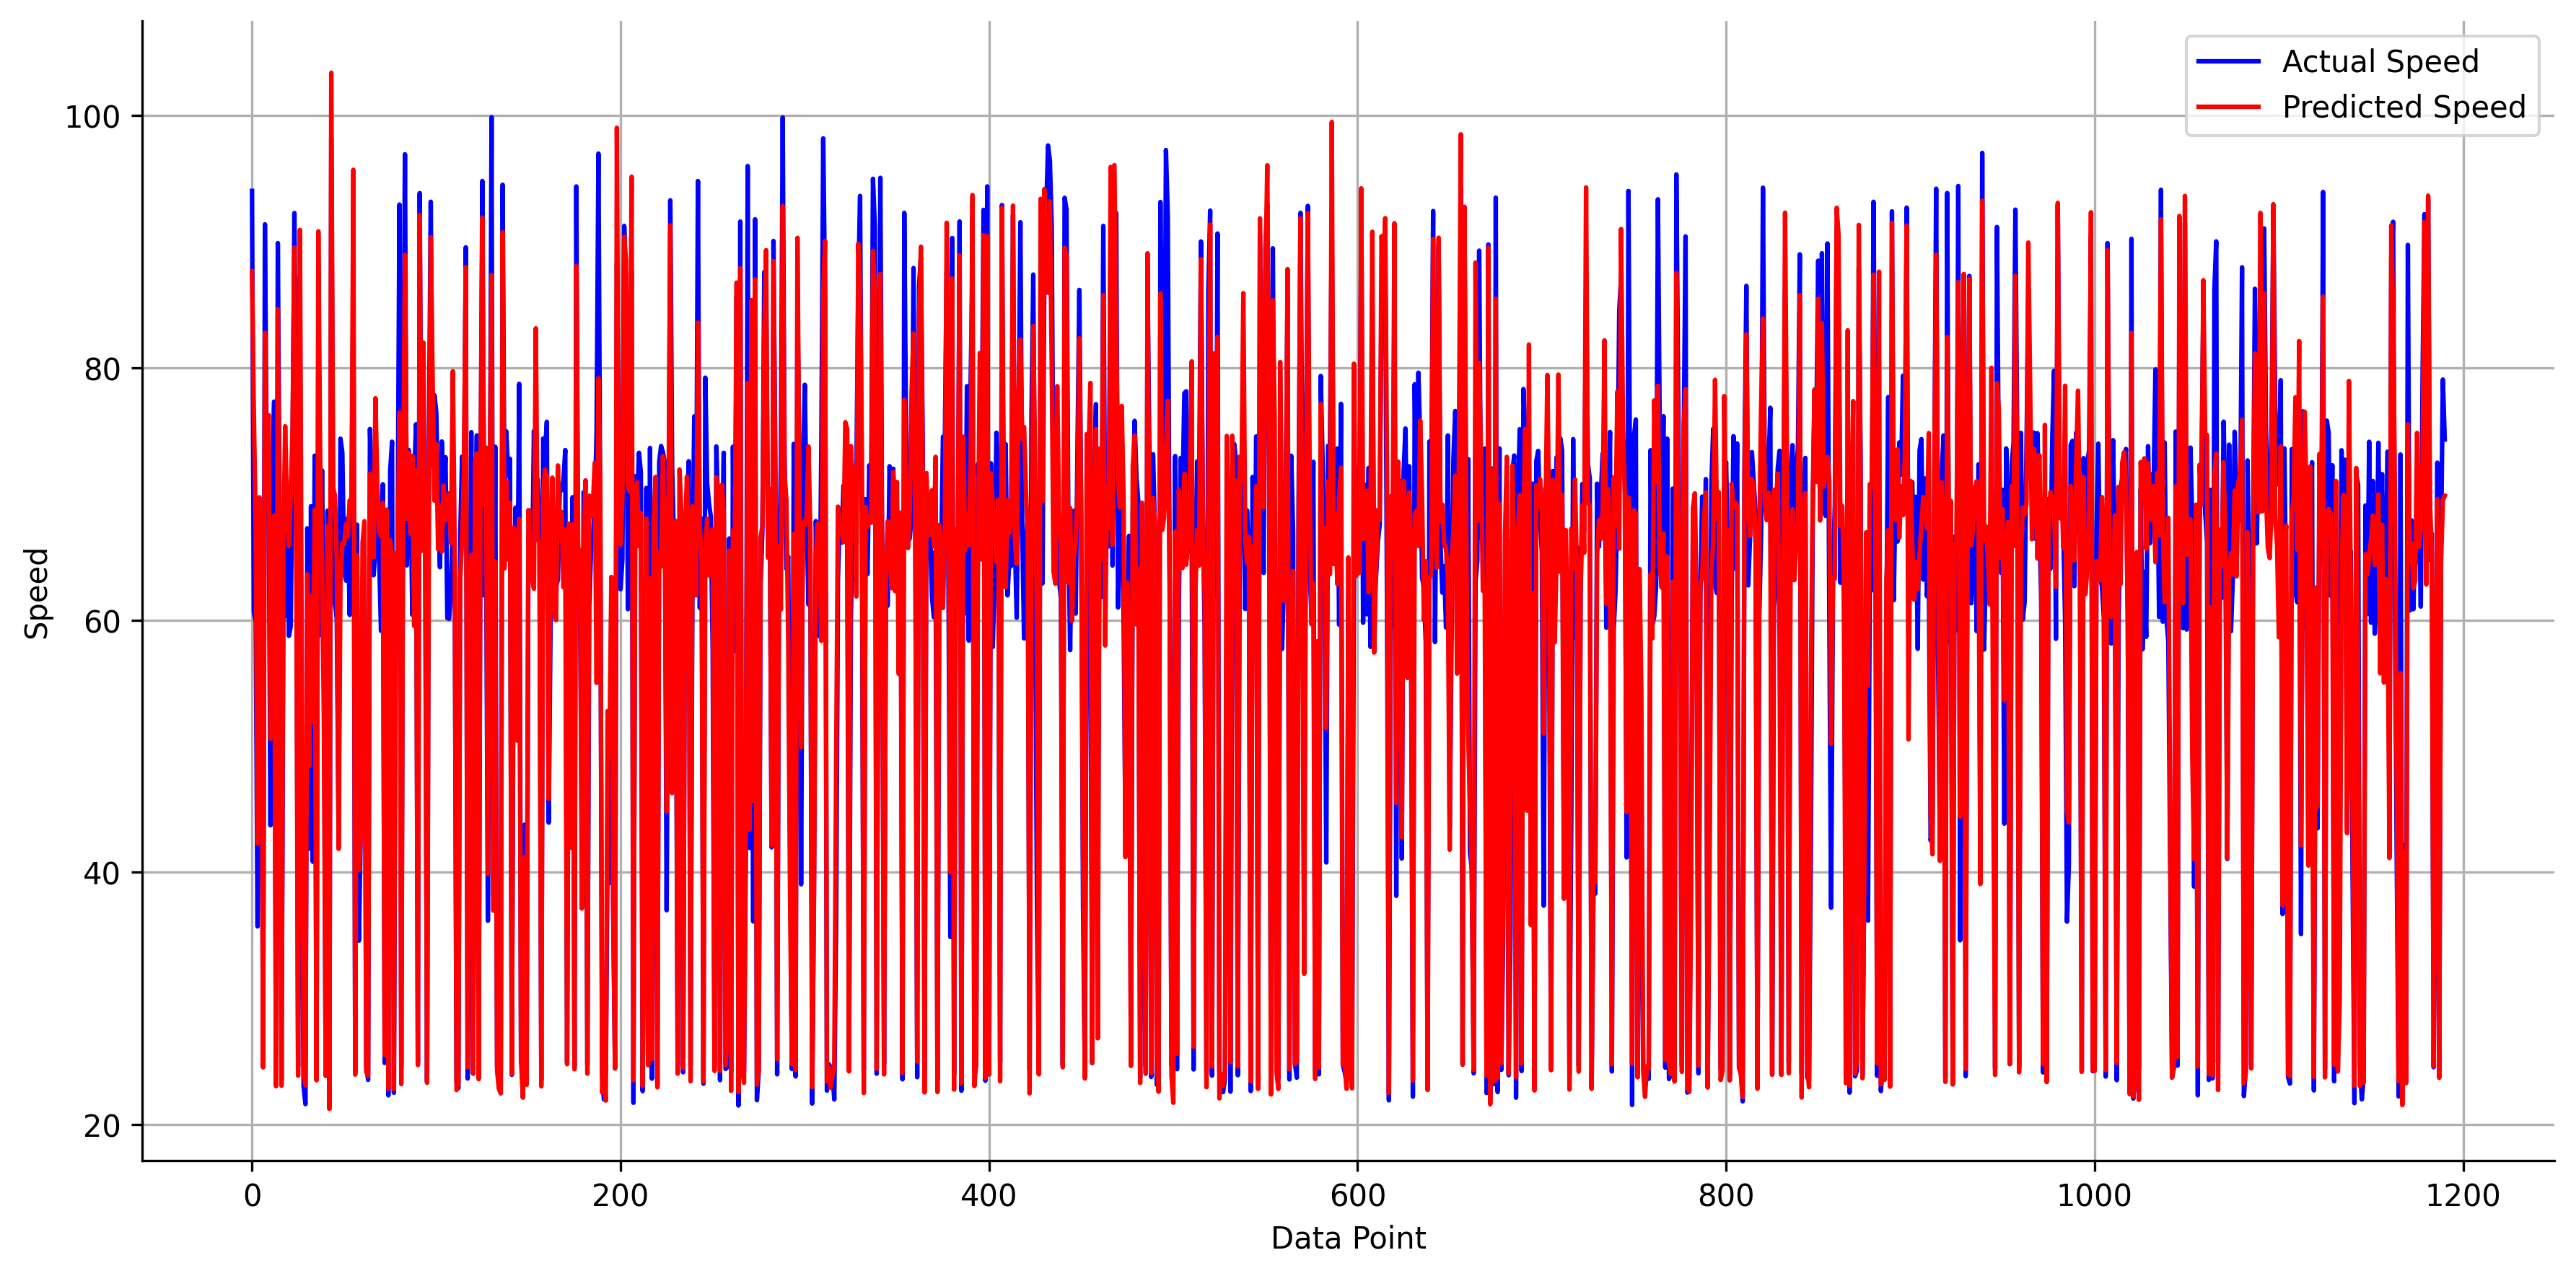

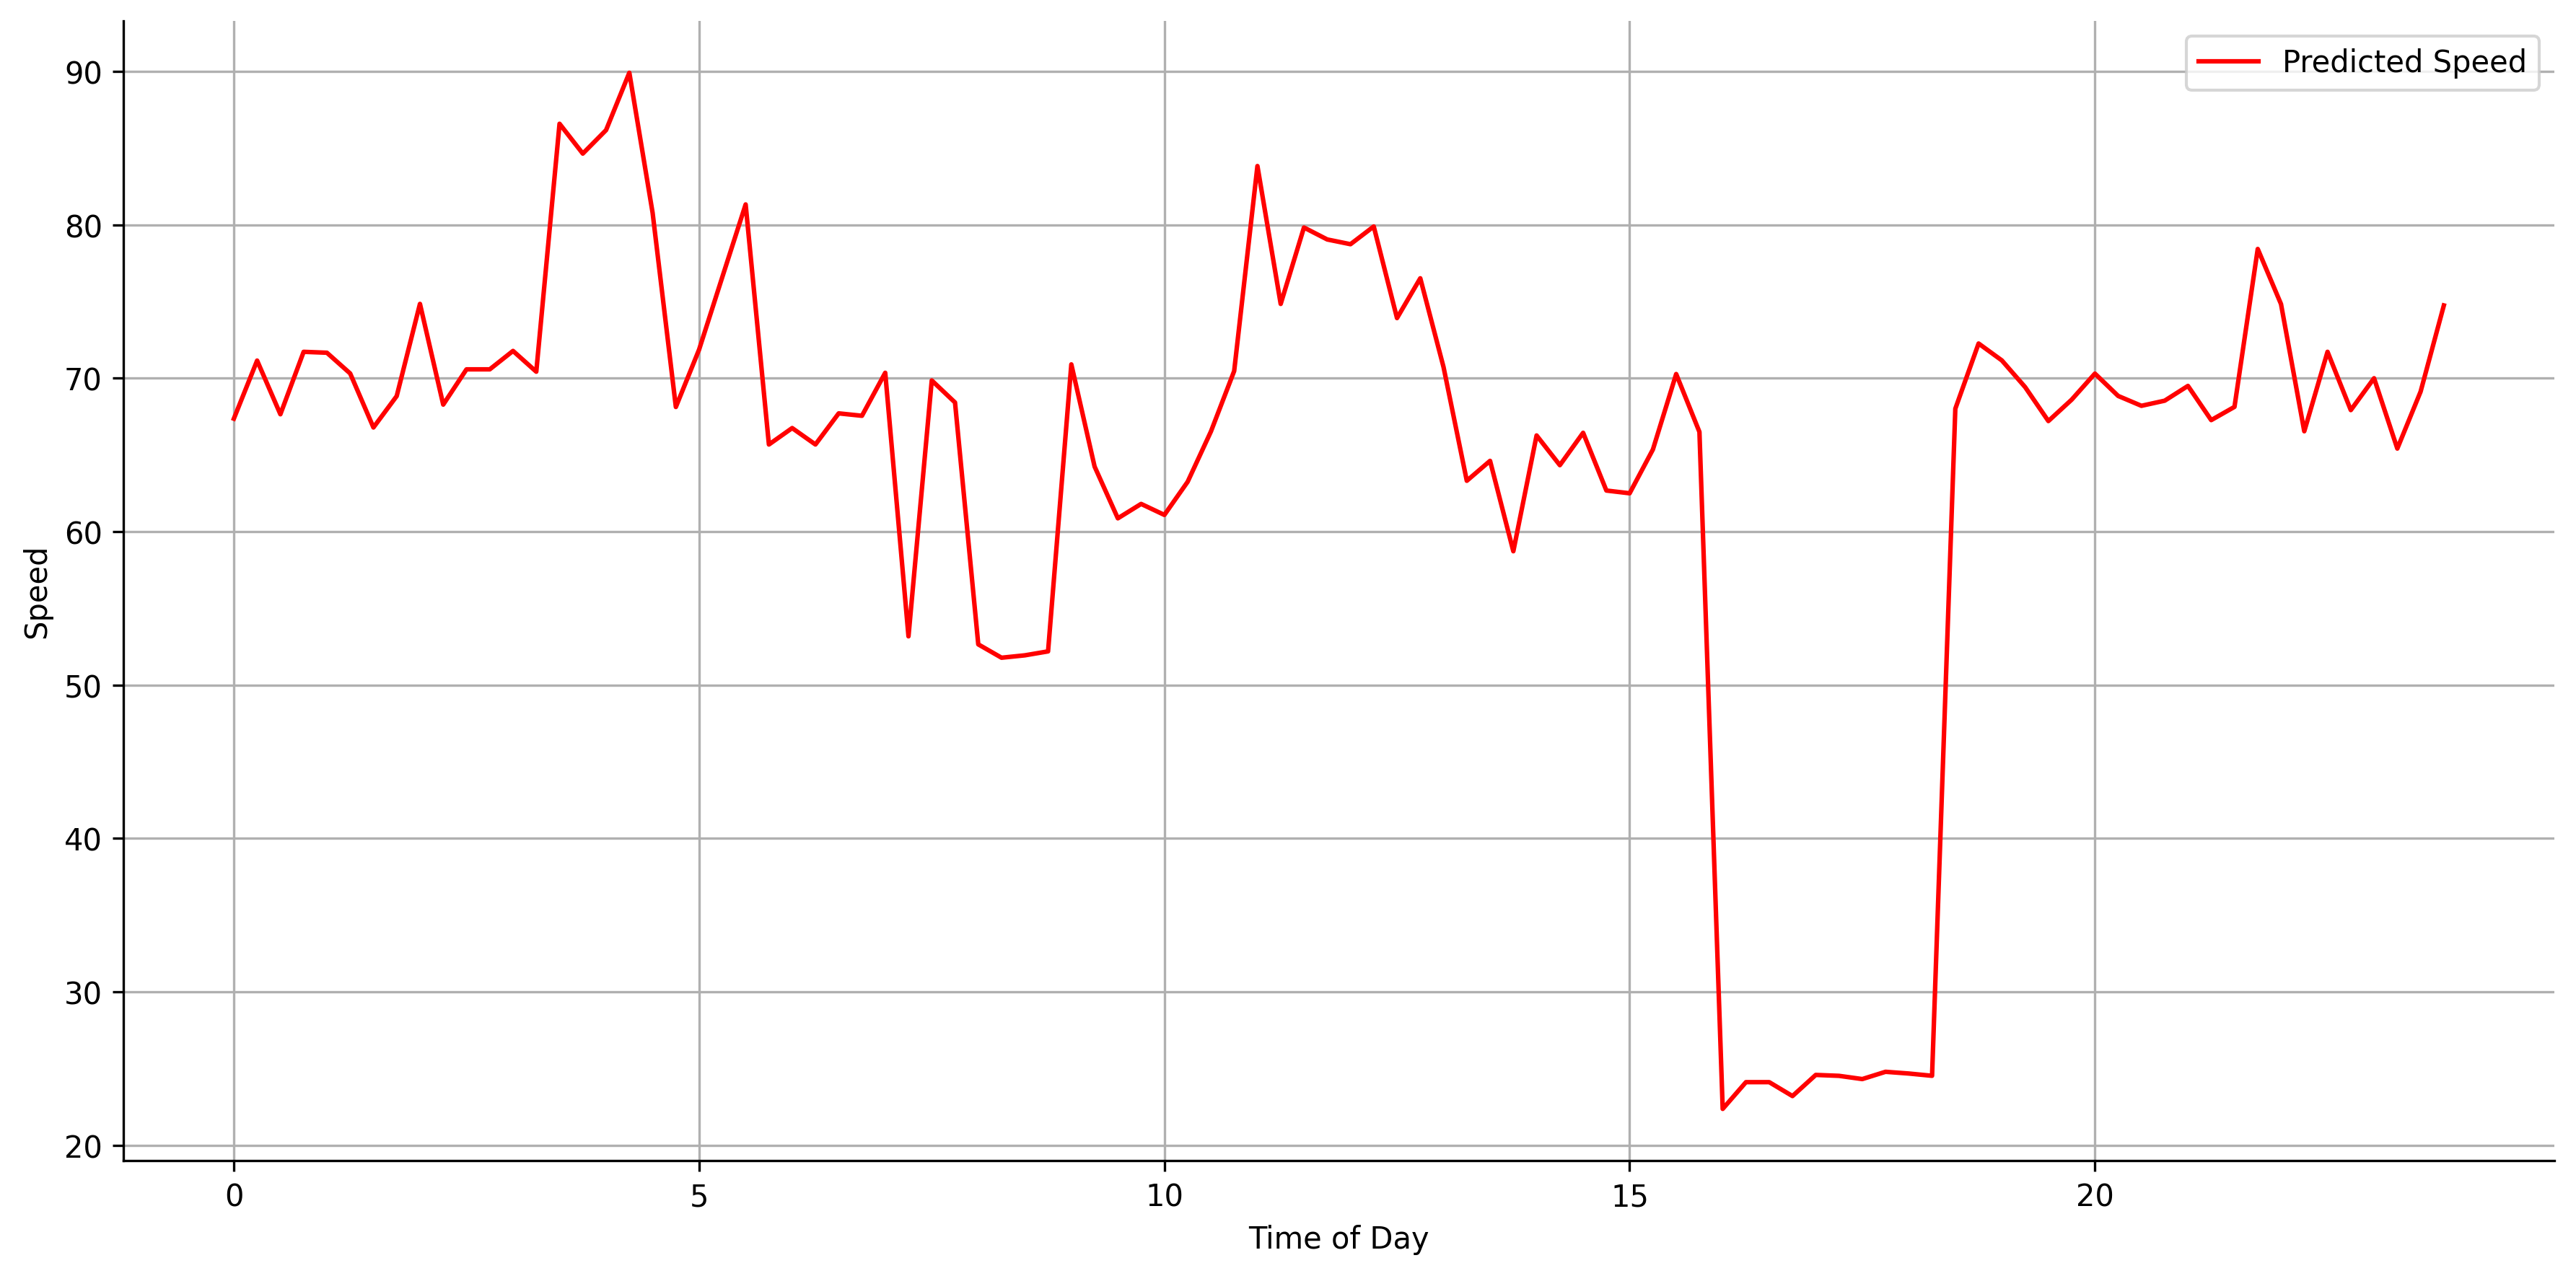

In [30]:
# This version is more optimized, efficient, and maintains better practices in handling data transformation and predictions.


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('TrafficTwoMonth.csv')

# Convert 'Time' column to datetime format 
df['Time'] = pd.to_datetime(df['Time'])

# Feature Engineering based on specific time
# Extract hour and minute from the 'Time' column
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Time of Day'] = df['Hour'] + df['Minute'] / 60.0

# Encode 'Day of the week' using LabelEncoder
label_encoder = LabelEncoder()
df['Day of the week'] = label_encoder.fit_transform(df['Day of the week'])

# Create a binary feature for weekends
df['Weekend'] = (df['Day of the week'] >= 5).astype(int)

# Create interaction terms for vehicle counts
df['Total Vehicle Count'] = df['CarCount'] + df['BikeCount'] + df['BusCount'] + df['TruckCount']
df['Car_Bus_Count'] = df['CarCount'] * df['BusCount']
df['Car_Truck_Count'] = df['CarCount'] * df['TruckCount']
df['Bus_Truck_Count'] = df['BusCount'] * df['TruckCount']

# Define speed ranges for different traffic situations
speed_ranges = {
    'low': (80, 100),
    'normal': (50, 80),
    'high': (30, 50),
    'heavy': (20, 30)
}

# Vectorize the probabilistic speed mapping
# Map 'Traffic Situation' to min_speed and max_speed
df['min_speed'] = df['Traffic Situation'].map(lambda x: speed_ranges[x][0])
df['max_speed'] = df['Traffic Situation'].map(lambda x: speed_ranges[x][1])

# Compute 'bias_factor' based on 'Time of Day'
rush_hour = ((df['Time of Day'] >= 7) & (df['Time of Day'] <= 9)) | ((df['Time of Day'] >= 17) & (df['Time of Day'] <= 19))
df['bias_factor'] = np.where(rush_hour, 0.7, 0.3)

# Adjust 'min_speed' and 'max_speed' based on 'Total Vehicle Count'
df['adjusted_min_speed'] = df['min_speed'] + np.where(df['Total Vehicle Count'] < 20, 5, 0)
df['adjusted_max_speed'] = df['max_speed'] - np.where(df['Total Vehicle Count'] > 50, 5, 0)

# Ensure 'adjusted_min_speed' does not exceed 'adjusted_max_speed'
df['adjusted_min_speed'] = np.minimum(df['adjusted_min_speed'], df['adjusted_max_speed'])

# Compute the lower bound for uniform distribution
df['lower_bound'] = df['adjusted_min_speed'] + df['bias_factor'] * (df['adjusted_max_speed'] - df['adjusted_min_speed'])

# Generate 'Probabilistic Speed'
np.random.seed()  
df['Probabilistic Speed'] = np.random.uniform(df['lower_bound'], df['adjusted_max_speed'])

# Use the new probabilistic speed as the target variable
y = df['Probabilistic Speed']

# Select relevant features for prediction (including 'Time of Day')
X = df[['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 
        'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBRegressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("\nMean Absolute Error (MAE) of the XGBRegressor model:", mae)

# Evaluate the model using R² score
r2 = r2_score(y_test, y_pred)
print("\nR² score (Accuracy) of the XGBRegressor model:", r2)

# Correlation between the predicted and actual values
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print("\nCorrelation between the predicted and actual values:", correlation)

# Predict speed for a new sample data at a specific time (e.g., 9:45 AM)
sample_data = {
    'Time of Day': [9 + 45 / 60.0],  # 9:45 AM represented as 9.75
    'Day of the week': [1], # Assuming Tuesday
    'Weekend': [0],
    'Total Vehicle Count': [50],
    'Car_Bus_Count': [10],
    'Car_Truck_Count': [15],
    'Bus_Truck_Count': [20]
}
sample_df = pd.DataFrame(sample_data)

# Make speed predictions for the sample data
speed_prediction = xgb_regressor.predict(sample_df)
print("\nPredicted speed for the sample data (9:45 AM):", speed_prediction)

# Plot the predicted vs. actual speed values over time for the test set
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(y_test.values, label='Actual Speed', color='blue')
plt.plot(y_pred, label='Predicted Speed', color='red')

plt.xlabel('Data Point')
plt.ylabel('Speed')


# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(True)
plt.show()

# Predict the speed of the truck for the whole day at every 15-minute interval
time_values = np.arange(0, 24, 0.25)
day_df = pd.DataFrame({'Time of Day': time_values})

# Aggregate df to have average vehicle counts per 'Time of Day'
aggregated_df = df.groupby('Time of Day').agg({
    'Total Vehicle Count': 'mean',
    'Car_Bus_Count': 'mean',
    'Car_Truck_Count': 'mean',
    'Bus_Truck_Count': 'mean'
}).reset_index()

# Merge day_df with the aggregated_df to include necessary columns
day_df = pd.merge(day_df, aggregated_df, on='Time of Day', how='left')

# Set 'Day of the week' and 'Weekend' to default values (e.g., Wednesday)
day_df['Day of the week'] = 2  # Assuming Wednesday
day_df['Weekend'] = 0

# Fill any missing values with interpolation
day_df.interpolate(method='linear', inplace=True)

# Make speed predictions for the whole day 
day_df['Predicted Speed'] = xgb_regressor.predict(day_df[['Time of Day', 'Day of the week', 'Weekend', 
                                                          'Total Vehicle Count', 'Car_Bus_Count', 
                                                          'Car_Truck_Count', 'Bus_Truck_Count']])

# Save the results to a CSV file
day_df.to_csv('Predicted_Speeds.csv', index=False)

# Visualizing the Predicted Speeds for the whole day
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(day_df['Time of Day'], day_df['Predicted Speed'], label='Predicted Speed', color='red')
plt.xlabel('Time of Day')
plt.ylabel('Speed')

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(True)
plt.show()

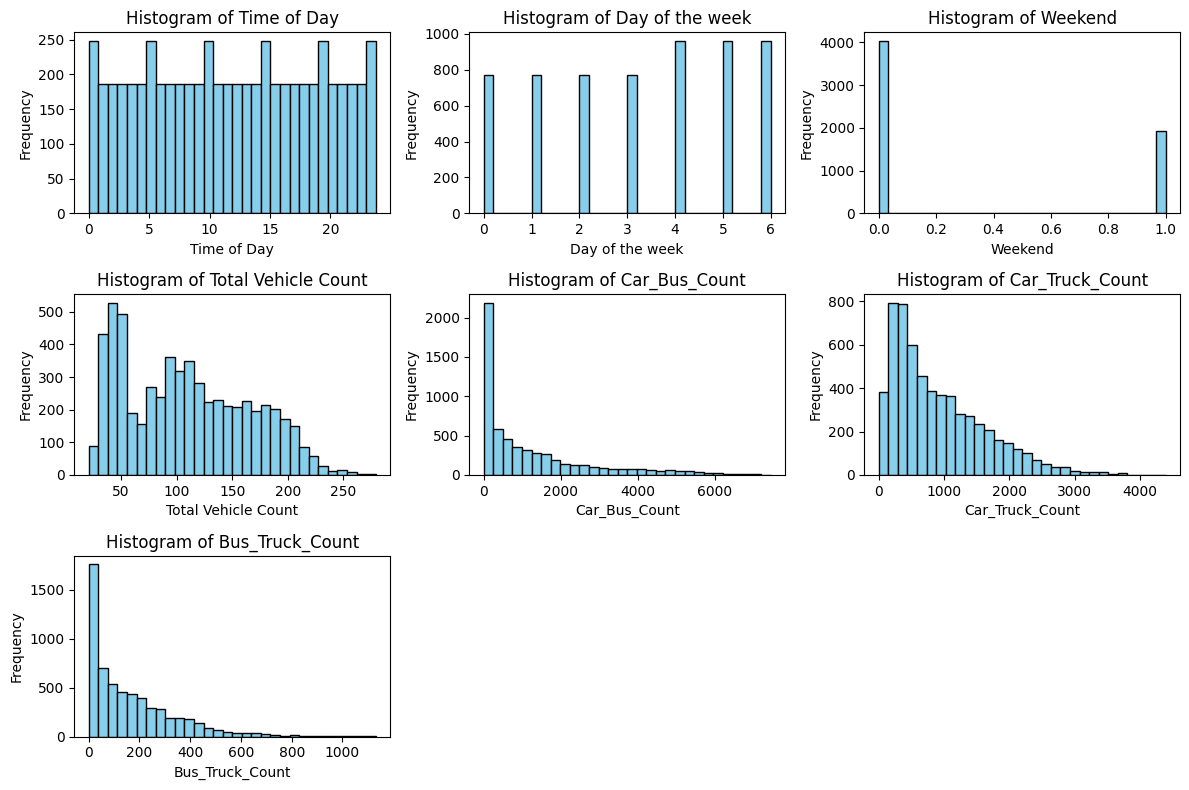

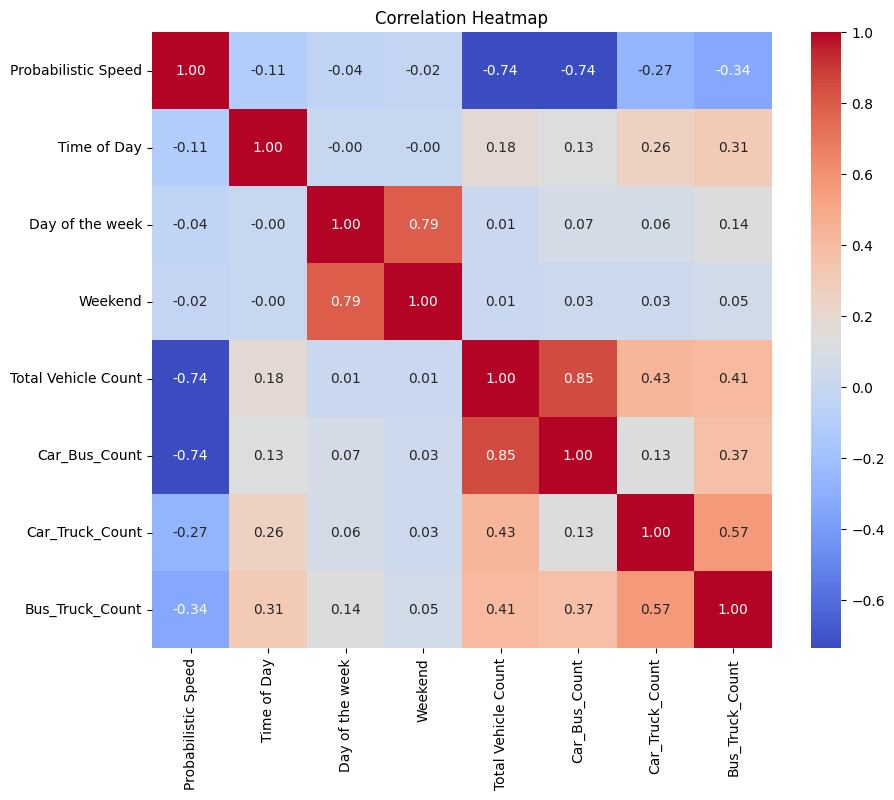


Mean Absolute Error (MAE) of the XGBRegressor model: 6.49094555838441

R² score (Accuracy) of the XGBRegressor model: 0.8327711882176895

Correlation between the predicted and actual values: 0.9126477728447191


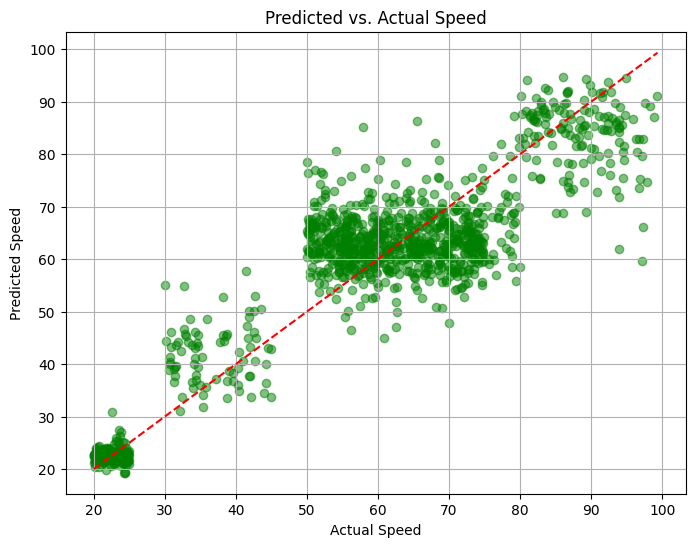

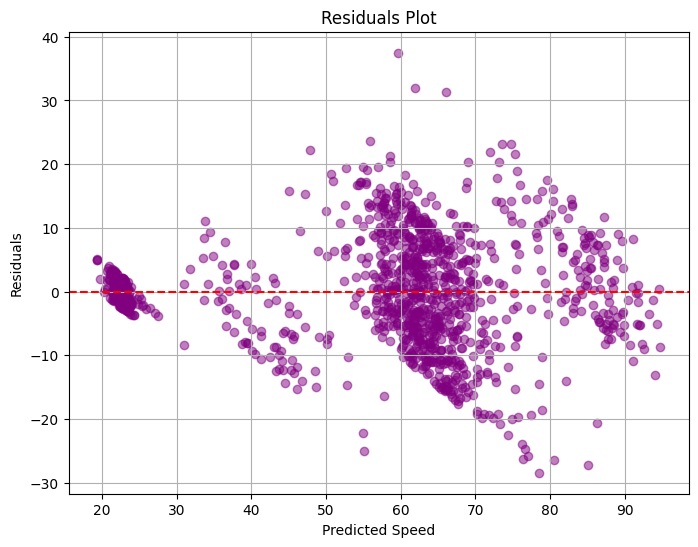

<Figure size 1000x600 with 0 Axes>

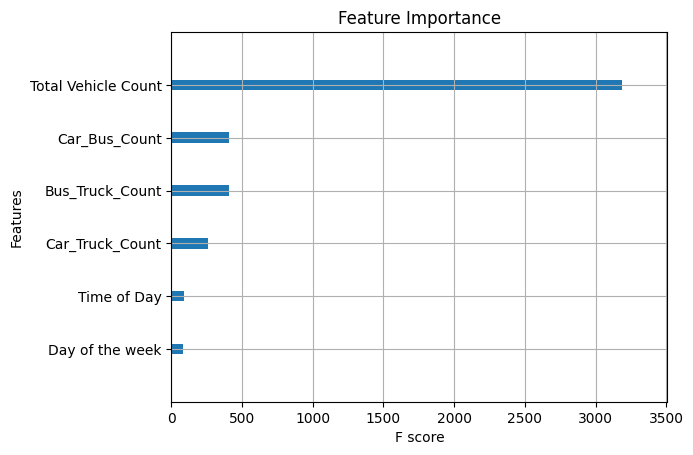


Predicted speed for the sample data (9:45 AM): [78.89537]


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Added for advanced plotting
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Load the dataset
df = pd.read_csv('TrafficTwoMonth.csv')

# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Feature Engineering based on specific time
# Extract hour and minute from the 'Time' column
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Time of Day'] = df['Hour'] + df['Minute'] / 60.0

# Encode 'Day of the week' using LabelEncoder
label_encoder = LabelEncoder()
df['Day of the week'] = label_encoder.fit_transform(df['Day of the week'])

# Create a binary feature for weekends
df['Weekend'] = (df['Day of the week'] >= 5).astype(int)

# Create interaction terms for vehicle counts
df['Total Vehicle Count'] = df['CarCount'] + df['BikeCount'] + df['BusCount'] + df['TruckCount']
df['Car_Bus_Count'] = df['CarCount'] * df['BusCount']
df['Car_Truck_Count'] = df['CarCount'] * df['TruckCount']
df['Bus_Truck_Count'] = df['BusCount'] * df['TruckCount']

# Define speed ranges for different traffic situations
speed_ranges = {
    'low': (80, 100),
    'normal': (50, 80),
    'high': (30, 50),
    'heavy': (20, 30)
}

# Vectorize the probabilistic speed mapping
# Map 'Traffic Situation' to min_speed and max_speed
df['min_speed'] = df['Traffic Situation'].map(lambda x: speed_ranges[x][0])
df['max_speed'] = df['Traffic Situation'].map(lambda x: speed_ranges[x][1])

# Compute 'bias_factor' based on 'Time of Day'
rush_hour = ((df['Time of Day'] >= 7) & (df['Time of Day'] <= 9)) | ((df['Time of Day'] >= 17) & (df['Time of Day'] <= 19))
df['bias_factor'] = np.where(rush_hour, 0.7, 0.3)

# Adjust 'min_speed' and 'max_speed' based on 'Total Vehicle Count'
df['adjusted_min_speed'] = df['min_speed'] + np.where(df['Total Vehicle Count'] < 20, 5, 0)
df['adjusted_max_speed'] = df['max_speed'] - np.where(df['Total Vehicle Count'] > 50, 5, 0)

# Ensure 'adjusted_min_speed' does not exceed 'adjusted_max_speed'
df['adjusted_min_speed'] = np.minimum(df['adjusted_min_speed'], df['adjusted_max_speed'])

# Generate 'Probabilistic Speed'
np.random.seed(42)  # For reproducibility
df['Probabilistic Speed'] = np.random.uniform(df['adjusted_min_speed'], df['adjusted_max_speed'])

# 1. Data Distribution Plots
# Plot histograms of key features
features_to_plot = ['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 
                    'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i+1)
    plt.hist(df[feature], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[['Probabilistic Speed'] + features_to_plot].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Use the new probabilistic speed as the target variable
y = df['Probabilistic Speed']

# Select relevant features for prediction (including 'Time of Day')
X = df[['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 
        'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBRegressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("\nMean Absolute Error (MAE) of the XGBRegressor model:", mae)

# Evaluate the model using R² score
r2 = r2_score(y_test, y_pred)
print("\nR² score (Accuracy) of the XGBRegressor model:", r2)

# Correlation between the predicted and actual values
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print("\nCorrelation between the predicted and actual values:", correlation)

# 2. Model Performance Plots

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Predicted vs. Actual Speed')
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Speed')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# 3. Feature Importance Plot
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_regressor, max_num_features=10, importance_type='gain', show_values=False)
plt.title('Feature Importance')
plt.show()

# Predict speed for a new sample data at a specific time (e.g., 9:45 AM)
sample_data = {
    'Time of Day': [9 + 45 / 60.0],  # 9:45 AM represented as 9.75
    'Day of the week': [1],
    'Weekend': [0],
    'Total Vehicle Count': [50],
    'Car_Bus_Count': [10],
    'Car_Truck_Count': [15],
    'Bus_Truck_Count': [20]
}
sample_df = pd.DataFrame(sample_data)

# Make speed predictions for the sample data
speed_prediction = xgb_regressor.predict(sample_df)
print("\nPredicted speed for the sample data (9:45 AM):", speed_prediction)


# 5. Predict the speed of the truck for the whole day at every 15-minute interval
time_values = np.arange(0, 24, 0.25)
day_df = pd.DataFrame({'Time of Day': time_values})

# Aggregate df to have average vehicle counts per 'Time of Day'
aggregated_df = df.groupby('Time of Day').agg({
    'Total Vehicle Count': 'mean',
    'Car_Bus_Count': 'mean',
    'Car_Truck_Count': 'mean',
    'Bus_Truck_Count': 'mean'
}).reset_index()

# Merge day_df with the aggregated_df to include necessary columns
day_df = pd.merge(day_df, aggregated_df, on='Time of Day', how='left')

# Set 'Day of the week' and 'Weekend' to default values (e.g., Wednesday)
day_df['Day of the week'] = 2  # Assuming Wednesday
day_df['Weekend'] = 0

# Fill any missing values with interpolation
day_df.interpolate(method='linear', inplace=True)

# Make speed predictions for the whole day 
day_df['Predicted Speed'] = xgb_regressor.predict(day_df[['Time of Day', 'Day of the week', 'Weekend', 
                                                          'Total Vehicle Count', 'Car_Bus_Count', 
                                                          'Car_Truck_Count', 'Bus_Truck_Count']])

# Save the results to a CSV file
day_df.to_csv('Predicted_Speeds.csv', index=False)




XGBoost Model Evaluation:
Mean Absolute Error (MAE): 0.7790935765128615
R² score: 0.9974221616752879


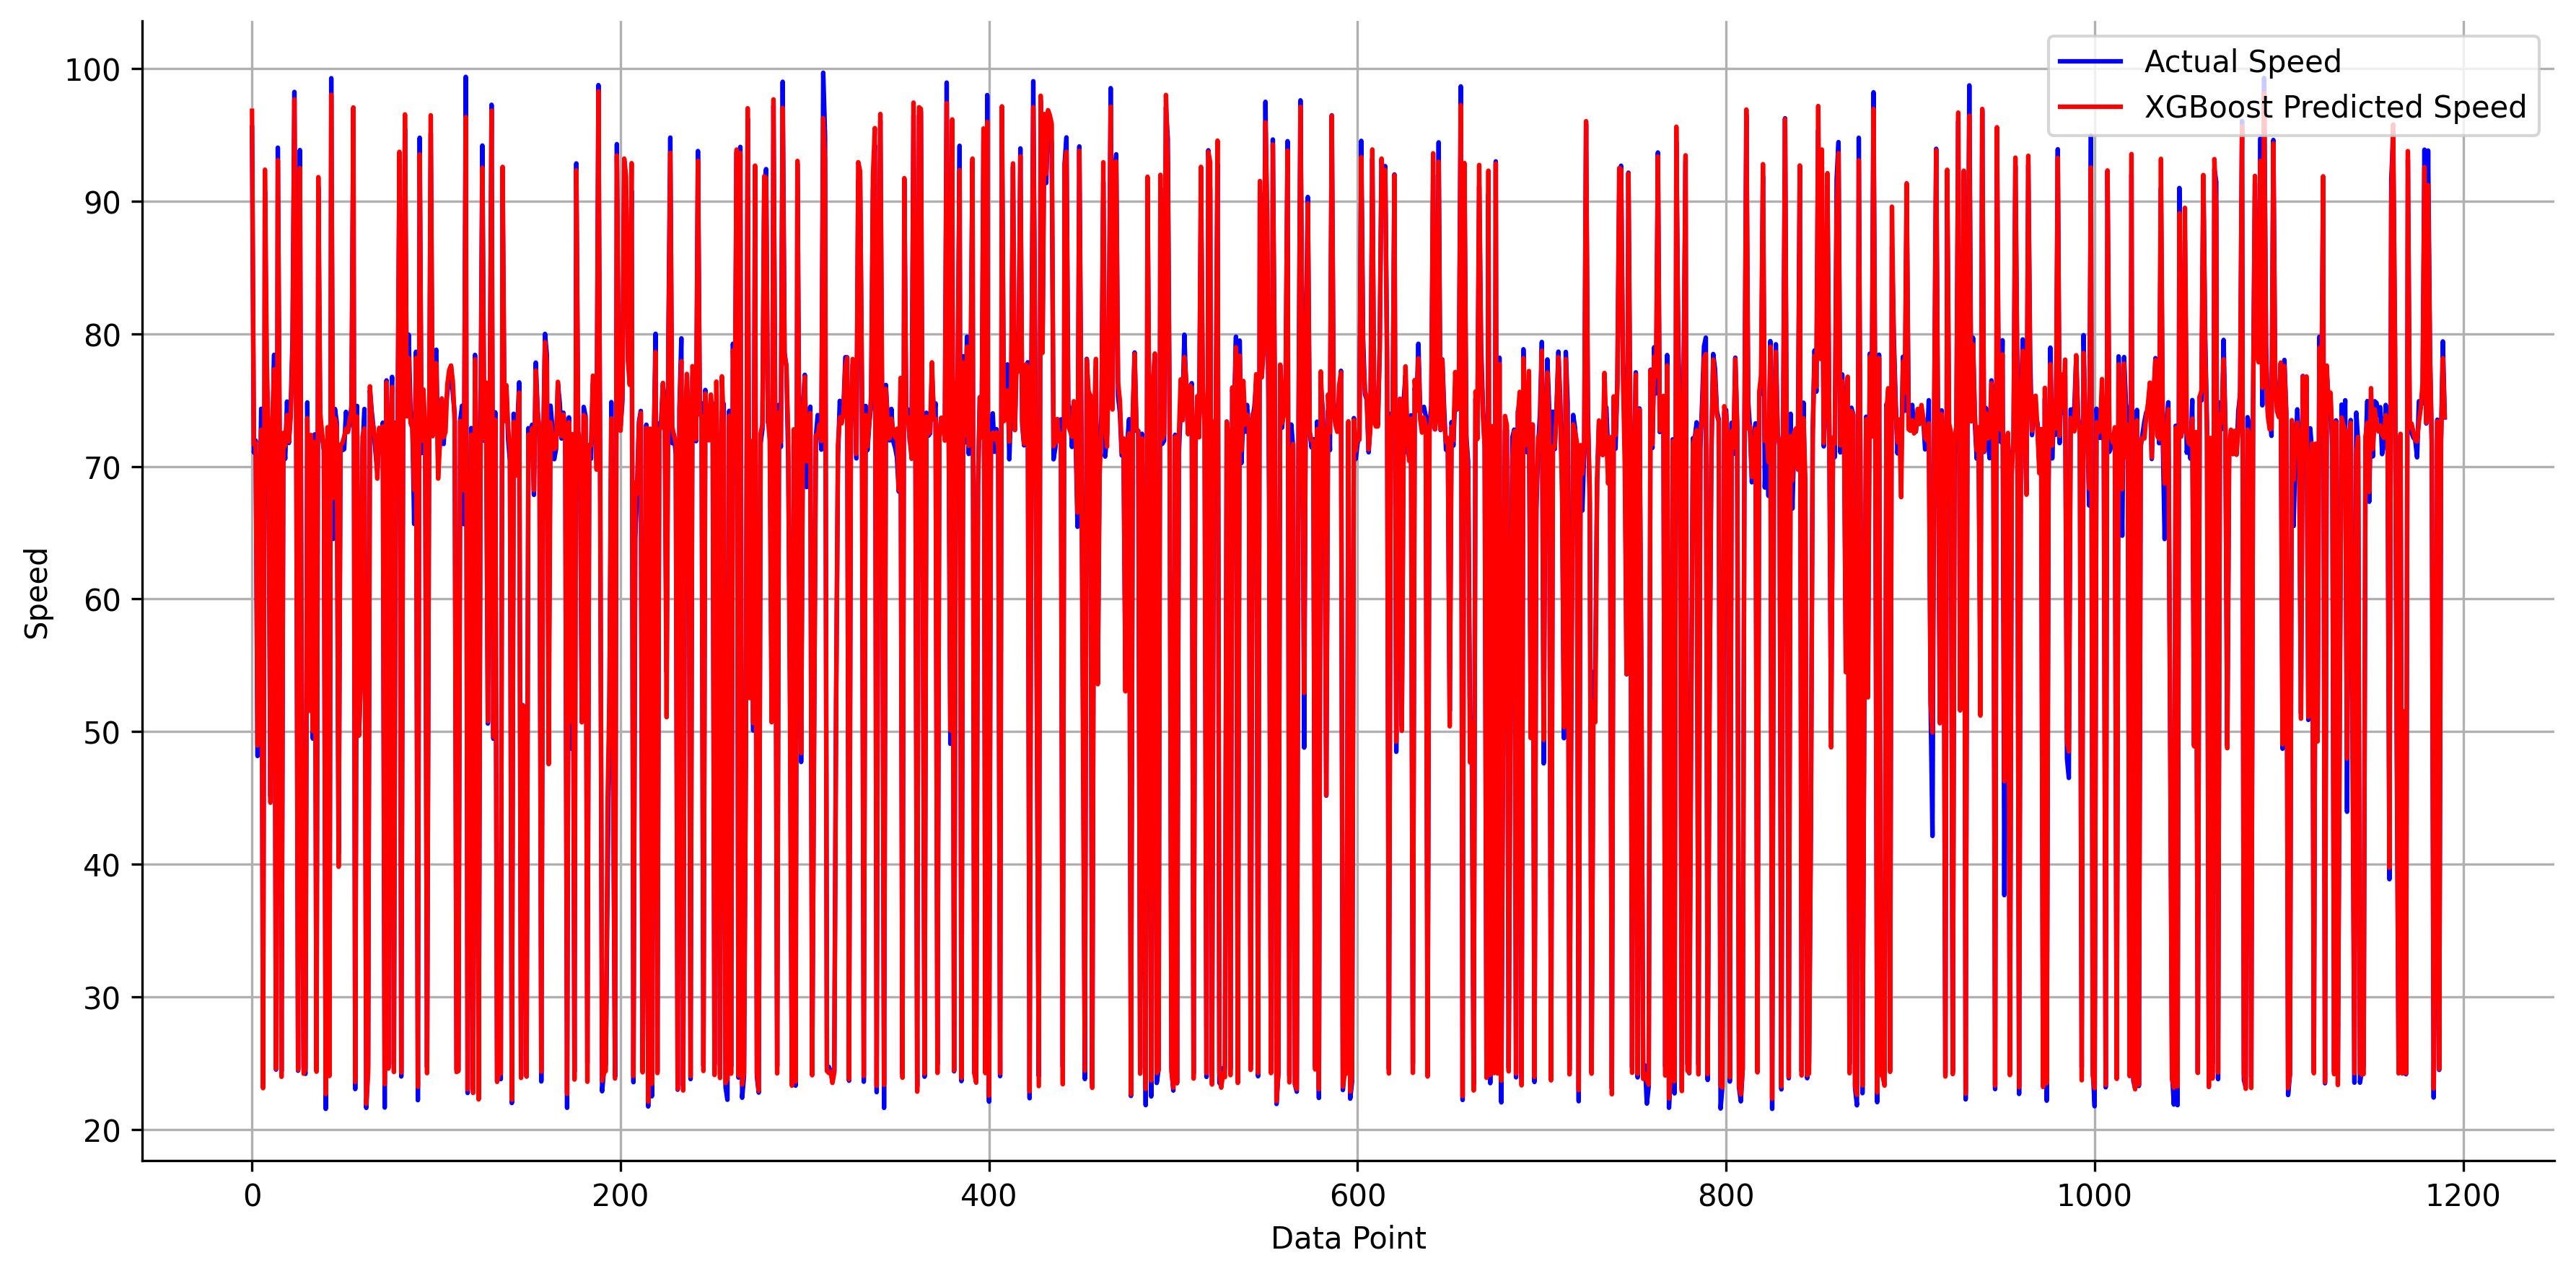

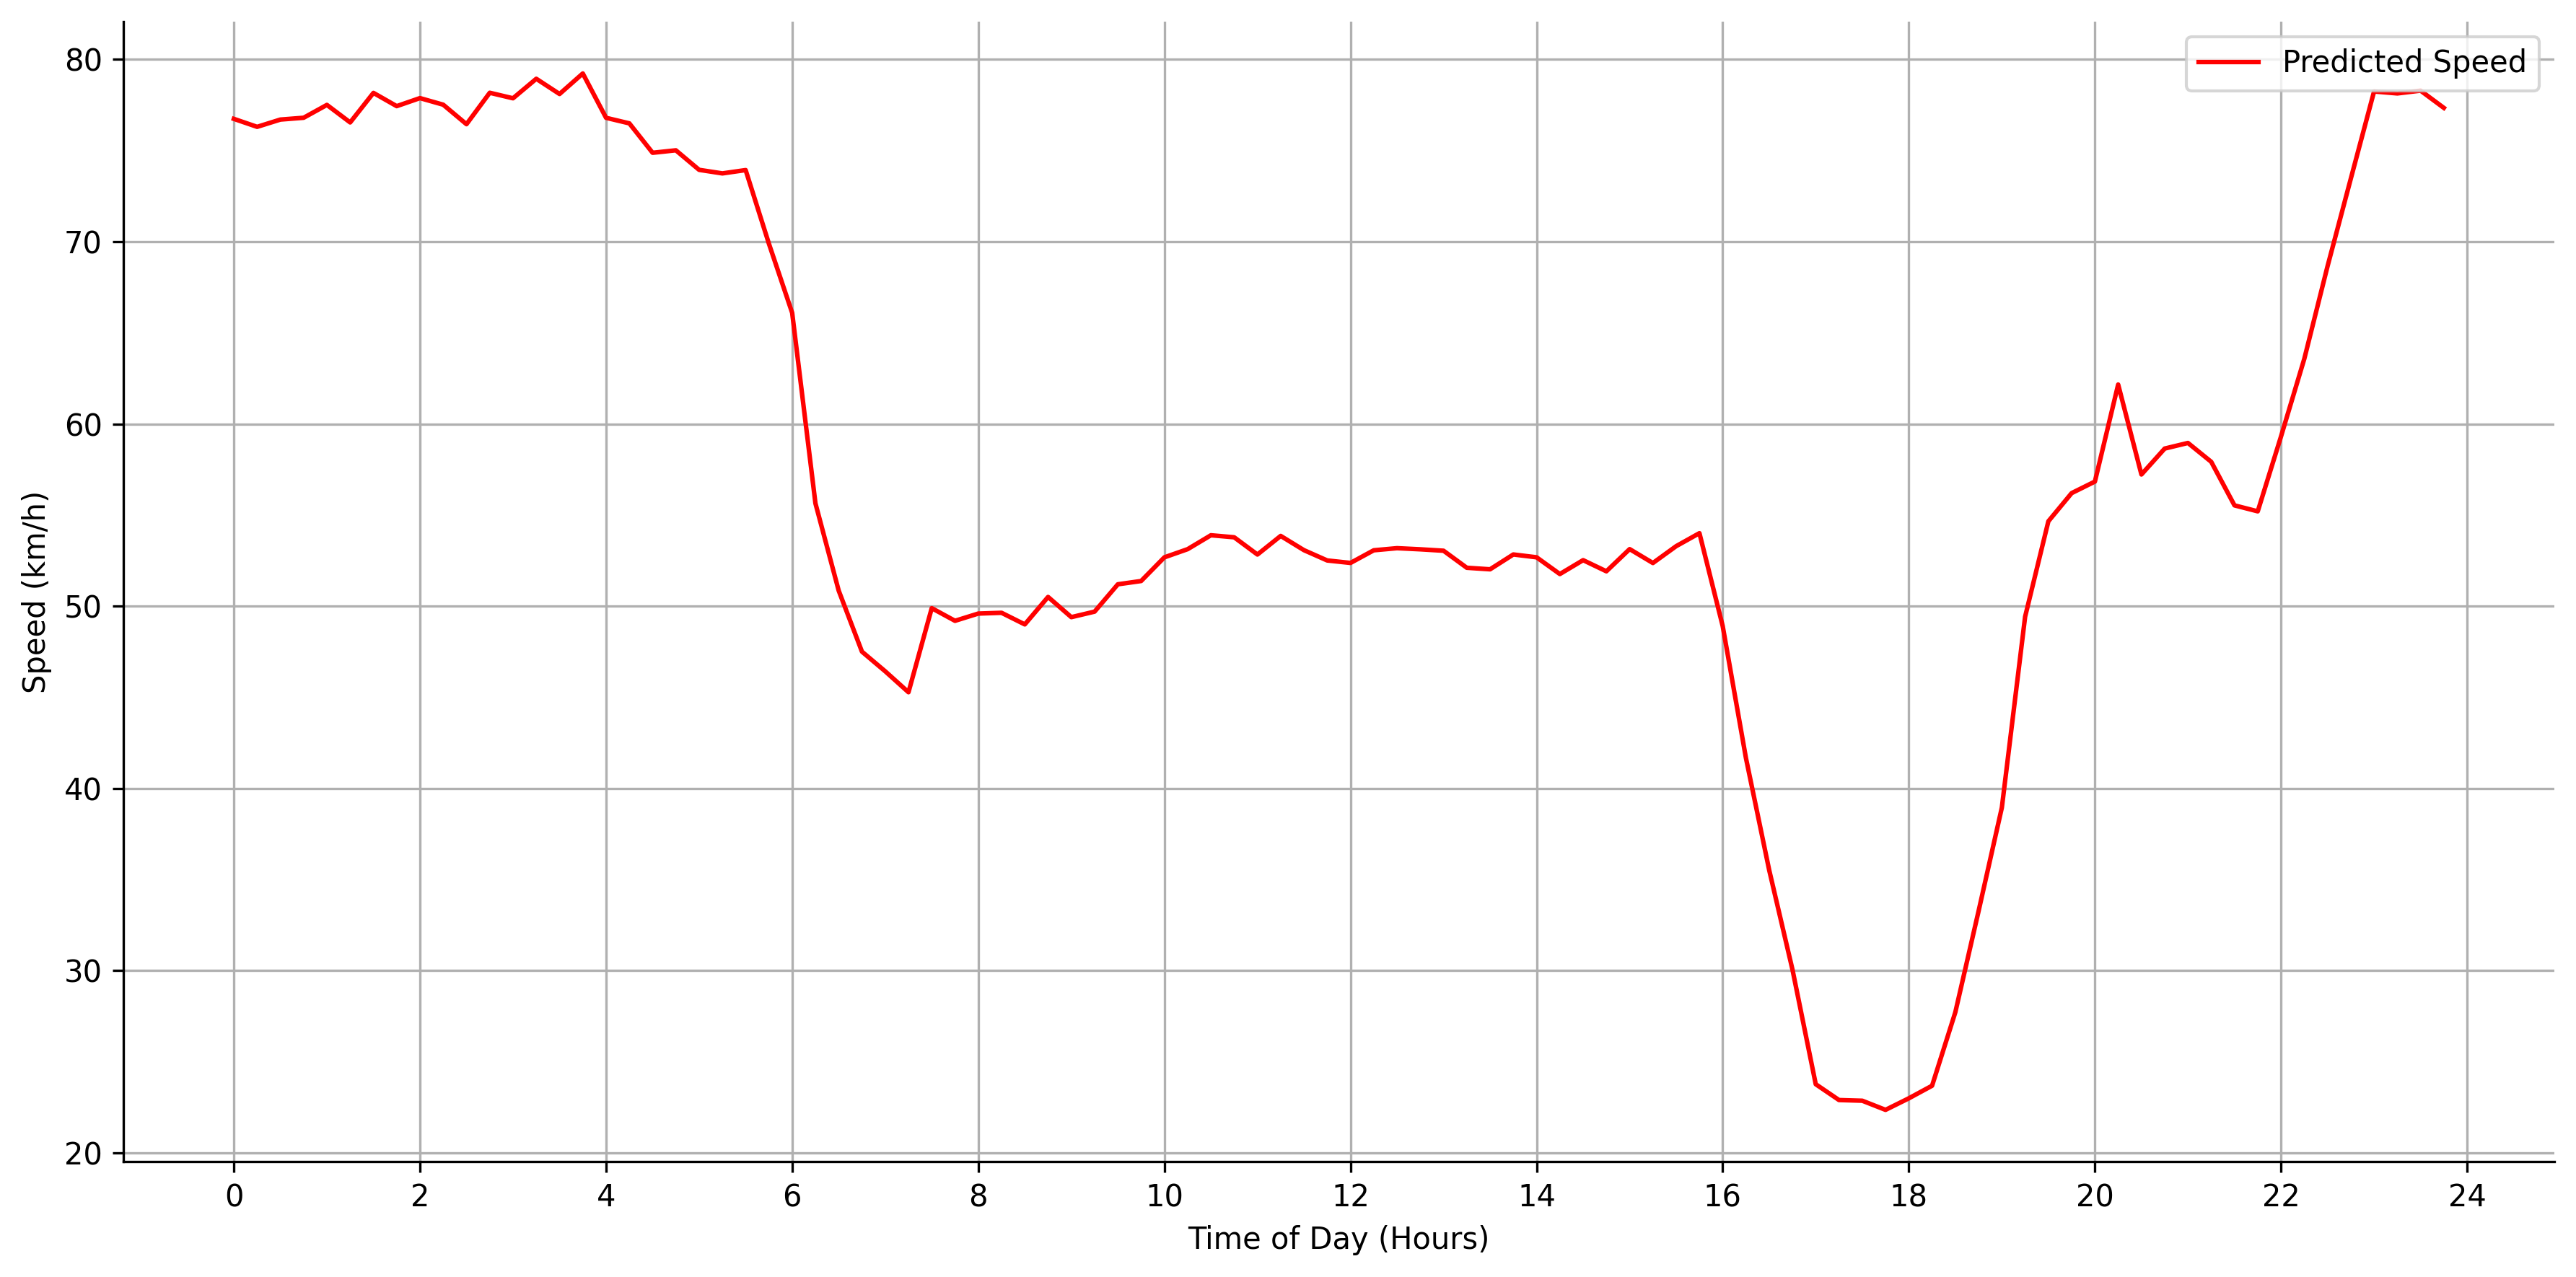

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('TrafficTwoMonth.csv')

# Convert 'Time' column to datetime format 
df['Time'] = pd.to_datetime(df['Time'])

# Feature Engineering based on specific time
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Time of Day'] = df['Hour'] + df['Minute'] / 60.0

# Encode 'Day of the week' using LabelEncoder
label_encoder = LabelEncoder()
df['Day of the week'] = label_encoder.fit_transform(df['Day of the week'])

# Create a binary feature for weekends
df['Weekend'] = (df['Day of the week'] >= 5).astype(int)

# Create interaction terms for vehicle counts
df['Total Vehicle Count'] = df['CarCount'] + df['BikeCount'] + df['BusCount'] + df['TruckCount']
df['Car_Bus_Count'] = df['CarCount'] * df['BusCount']
df['Car_Truck_Count'] = df['CarCount'] * df['TruckCount']
df['Bus_Truck_Count'] = df['BusCount'] * df['TruckCount']

# Define speed ranges for different traffic situations
speed_ranges = {
    'low': (80, 100),
    'normal': (60, 80),
    'high': (30, 60),
    'heavy': (20, 30)
}

# Vectorize the probabilistic speed mapping
df['min_speed'] = df['Traffic Situation'].map(lambda x: speed_ranges[x][0])
df['max_speed'] = df['Traffic Situation'].map(lambda x: speed_ranges[x][1])

# Compute 'bias_factor' based on 'Time of Day'
rush_hour = ((df['Time of Day'] >= 7) & (df['Time of Day'] <= 9)) | ((df['Time of Day'] >= 17) & (df['Time of Day'] <= 19))
df['bias_factor'] = np.where(rush_hour, 0.7, 0.3)

# Adjust 'min_speed' and 'max_speed' based on 'Total Vehicle Count'
df['adjusted_min_speed'] = df['min_speed'] + np.where(df['Total Vehicle Count'] < 20, 5, 0)
df['adjusted_max_speed'] = df['max_speed'] - np.where(df['Total Vehicle Count'] > 50, 5, 0)
df['adjusted_min_speed'] = np.minimum(df['adjusted_min_speed'], df['adjusted_max_speed'])

# Compute the lower bound for uniform distribution
df['lower_bound'] = df['adjusted_min_speed'] + (1 - df['bias_factor']) * (df['adjusted_max_speed'] - df['adjusted_min_speed'])

# Generate 'Probabilistic Speed'
np.random.seed()  
df['Probabilistic Speed'] = np.random.uniform(df['lower_bound'], df['adjusted_max_speed'])

# Create lagged speed features and rolling statistics
df['Speed_Lag_1'] = df['Probabilistic Speed'].shift(1)
df['Speed_Lag_2'] = df['Probabilistic Speed'].shift(2)
df['Speed_Lag_3'] = df['Probabilistic Speed'].shift(3)
df['Speed_Rolling_Mean'] = df['Probabilistic Speed'].rolling(window=3).mean()
df['Speed_Rolling_STD'] = df['Probabilistic Speed'].rolling(window=3).std()
df.fillna(0, inplace=True)

# Use the new probabilistic speed as the target variable
y = df['Probabilistic Speed']

# Define the feature set
features = ['Time of Day', 'Day of the week', 'Weekend', 'Total Vehicle Count', 
            'Car_Bus_Count', 'Car_Truck_Count', 'Bus_Truck_Count', 
            'Speed_Lag_1', 'Speed_Lag_2', 'Speed_Lag_3', 
            'Speed_Rolling_Mean', 'Speed_Rolling_STD', 'bias_factor', 
            'adjusted_min_speed', 'adjusted_max_speed']

X = df[features]

# Split the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBRegressor
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    max_depth=6,         # Limit depth to control complexity
    learning_rate=0.1,   # Smaller learning rate for stability
    n_estimators=100,    # More trees for better generalization
    reg_alpha=0.5,       # L1 regularization
    reg_lambda=0.5       # L2 regularization
)
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test data using XGBoost
y_pred = xgb_regressor.predict(X_test)

# Evaluate the XGBoost model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nXGBoost Model Evaluation:")
print("Mean Absolute Error (MAE):", mae)
print("R² score:", r2)

# Visualizing the comparison between actual and XGBoost predictions
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(y_test.values, label='Actual Speed', color='blue')
plt.plot(y_pred, label='XGBoost Predicted Speed', color='red')

plt.xlabel('Data Point')
plt.ylabel('Speed')

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the results to a CSV file
df.to_csv('TrafficDataWithPredictions.csv', index=False)

# Predict the speed for the whole day at every 15-minute interval using XGBoost
time_values = np.arange(0, 24, 0.25)
day_df = pd.DataFrame({'Time of Day': time_values})

# Aggregate df to have average vehicle counts per 'Time of Day'
aggregated_df = df.groupby('Time of Day').agg({
    'Total Vehicle Count': 'mean',
    'Car_Bus_Count': 'mean',
    'Car_Truck_Count': 'mean',
    'Bus_Truck_Count': 'mean',
    'bias_factor': 'mean',
    'adjusted_min_speed': 'mean',
    'adjusted_max_speed': 'mean',
    'Probabilistic Speed' : 'mean'
}).reset_index()

# Merge day_df with the aggregated_df to include necessary columns
day_df = pd.merge(day_df, aggregated_df, on='Time of Day', how='left')

# Set 'Day of the week' and 'Weekend' to default values (e.g., Wednesday)
day_df['Day of the week'] = 2  # Assuming Wednesday
day_df['Weekend'] = 0

# Fill any missing values with interpolation
day_df.interpolate(method='linear', inplace=True)

# Create lagged speed features and rolling statistics
day_df['Speed_Lag_1'] = day_df['Probabilistic Speed'].shift(1)
day_df['Speed_Lag_2'] = day_df['Probabilistic Speed'].shift(2)
day_df['Speed_Lag_3'] = day_df['Probabilistic Speed'].shift(3)
day_df['Speed_Rolling_Mean'] = day_df['Probabilistic Speed'].rolling(window=3).mean()
day_df['Speed_Rolling_STD'] = day_df['Probabilistic Speed'].rolling(window=3).std()

# Fill NaN values caused by shifts/rolling calculations
day_df.fillna(0, inplace=True)

# Make speed predictions for the whole day using XGBoost
day_df['Predicted Speed'] = xgb_regressor.predict(day_df[['Time of Day', 'Day of the week', 'Weekend', 
                                                          'Total Vehicle Count', 'Car_Bus_Count', 
                                                          'Car_Truck_Count', 'Bus_Truck_Count', 
                                                          'Speed_Lag_1', 'Speed_Lag_2', 'Speed_Lag_3', 
                                                          'Speed_Rolling_Mean', 'Speed_Rolling_STD', 
                                                          'bias_factor', 'adjusted_min_speed', 'adjusted_max_speed']])

day_df['Predicted_Speed'] = day_df['Predicted Speed'].rolling(window=5, min_periods=1).mean() # Smoothing the predictions

np.random.seed()
noise = np.random.normal(0, 0.5, size=len(day_df['Predicted_Speed']))
day_df['Predicted_Speed'] = np.clip(
    day_df['Predicted_Speed'] + noise, 00, 100  # Keep within realistic range
)


# Save the results to a CSV file
day_df.to_csv('Predicted_Speeds.csv', index=False)

# Visualizing the Predicted Speeds for the Whole Day
# Step 1: Create tick positions for every 2.5-hour interval
x_ticks = np.append(np.arange(0, 24, 2), 24)  # From 0 to 24 with 2.5-hour steps, plus 24
# Step 2: Plot the graph with the modified x-axis ticks
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(day_df['Time of Day'], day_df['Predicted_Speed'], label='Predicted Speed', color='red')
# Step 3: Customize the plot title, labels, and grid
plt.xlabel('Time of Day (Hours)')
plt.ylabel('Speed (km/h)')
# Step 4: Apply the custom x-axis ticks and enable grid
plt.xticks(x_ticks)  # Set the x-axis ticks at 2.5-hour intervals
plt.grid(True)

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Step 5: Show the plot
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()





The plot you shared shows predicted vehicle speeds over a 24-hour period. Let's analyze its alignment with real-life traffic patterns based on typical traffic behavior:

Early Hours (0-5 AM):

Speed is high and relatively stable, which aligns with typical traffic conditions when roads are mostly clear.
Morning Rush Hour (6-9 AM):

There's a significant drop in speed around 6 AM, which corresponds with increased congestion during morning rush hours, matching real-life patterns.
Midday (10 AM-3 PM):

The speed stabilizes but remains slightly lower than early hours. This behavior is realistic, reflecting moderate traffic due to errands, school runs, or business activities.

Evening Rush Hour (4-7 PM):

There is another sharp decline in speed, which corresponds with the typical evening rush hour congestion. This is consistent with real-life expectations.
Evening to Late 

Night (8 PM-12 AM):

Speeds increase again as traffic eases. This reflects the gradual clearing of roads in the late evening.
Key Insights:

Realistic Trend Detection: The plot captures key traffic behaviors such as rush hours in the morning and evening.
Sudden Changes: If the speed drops and rises abruptly, it might indicate extreme congestion points or incidents, which may or may not be typical in real-world patterns unless there are specific factors (e.g., accidents or roadwork).
Prediction Validity: If this prediction is based on past data and real-time traffic updates, the curve appears reasonable and reflective of actual conditions.
This chart seems to align well with general expectations, but a comparison with real traffic data from the region you're studying would confirm how closely the prediction model captures local dynamics. Is there any specific discrepancy or observation you were expecting to discuss?

In [33]:
from datetime import time
from scipy.interpolate import interp1d

######################################
# Save the model to a file with extension .h5 and load the model from the saved file.
######################################

xgb_regressor.save_model('xgboost_model.h5')
print("\nXGBoost model saved to 'xgboost_model.h5' file.")

# Load the model from the saved file
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('xgboost_model.h5')
print("\nXGBoost model loaded successfully from 'xgboost_model.h5' file.")


######################################
# Make predictions using the loaded model for the speed of the truck at a time of 15 minutes interval.
######################################


# Step 1: Convert 4:12 PM to the fractional hour format
time_of_day_4_12_pm = 16 + 30 / 60  # 4:12 PM as 16.50

# Step 2: Locate the closest row in day_df (whole-day prediction DataFrame)
row_time = day_df[day_df['Time of Day'] == time_of_day_4_12_pm]

# Step 3: Verify if the row exists
if row_time.empty:
    print("No data found for the specified time 4:12 PM.")
else:
    # Extract the features for 4:12 PM
    X_time = row_time[[
        'Time of Day', 'Day of the week', 'Weekend', 
        'Total Vehicle Count', 'Car_Bus_Count', 'Car_Truck_Count', 
        'Bus_Truck_Count', 'Speed_Lag_1', 'Speed_Lag_2', 'Speed_Lag_3', 
        'Speed_Rolling_Mean', 'Speed_Rolling_STD', 'bias_factor', 
        'adjusted_min_speed', 'adjusted_max_speed'
    ]]

    # Step 4: Use the loaded model to predict the speed at 4:12 PM
    predicted_speed = loaded_model.predict(X_time)

    # Step 5: Output the predicted speed
    print(f"Predicted Speed at 16:30 PM: {predicted_speed[0]:.2f} km/h")


######################################
# Make predictions using the loaded model for the speed of the truck at any time of the day.
######################################

# Step 1: Create a DataFrame with finer resolution (1-minute intervals)
arbitrary_times = np.arange(0, 24, 1 / 60)  # 1-minute resolution
arbitrary_df = pd.DataFrame({'Time of Day': arbitrary_times})

# Step 2: Reindex the original data to cover the full day with finer time intervals
day_df_full = day_df.set_index('Time of Day').reindex(arbitrary_times).reset_index()
day_df_full.rename(columns={'index': 'Time of Day'}, inplace=True)

# Step 3: Interpolate all features linearly across the finer intervals
interpolated_df = day_df_full.interpolate(method='linear')

# Step 4: Generate predicted speeds at known times for interpolation
predicted_speed_values = loaded_model.predict(day_df[[
    'Time of Day', 'Day of the week', 'Weekend',
    'Total Vehicle Count', 'Car_Bus_Count', 'Car_Truck_Count',
    'Bus_Truck_Count', 'Speed_Lag_1', 'Speed_Lag_2', 'Speed_Lag_3',
    'Speed_Rolling_Mean', 'Speed_Rolling_STD', 'bias_factor',
    'adjusted_min_speed', 'adjusted_max_speed'
]])

# Create the interpolation function for speed
speed_interpolation = interp1d(
    day_df['Time of Day'].values, predicted_speed_values, kind='linear', fill_value="extrapolate"
)

# Step 5: Define the function to predict speed at any arbitrary time
def predict_speed_at(time_of_day):
    # Convert the given time into fractional hour format
    fractional_hour = time_of_day.hour + time_of_day.minute / 60

    # Use the interpolation function to predict the speed
    predicted_speed = speed_interpolation(fractional_hour)

    # Output the predicted speed
    print(f"Predicted Speed at {time_of_day.strftime('%I:%M %p')}: {predicted_speed:.2f} km/h")

# Test the function with specific times
predict_speed_at(time(6, 00)) 




XGBoost model saved to 'xgboost_model.h5' file.

XGBoost model loaded successfully from 'xgboost_model.h5' file.
Predicted Speed at 16:30 PM: 24.09 km/h
Predicted Speed at 06:00 AM: 51.81 km/h
